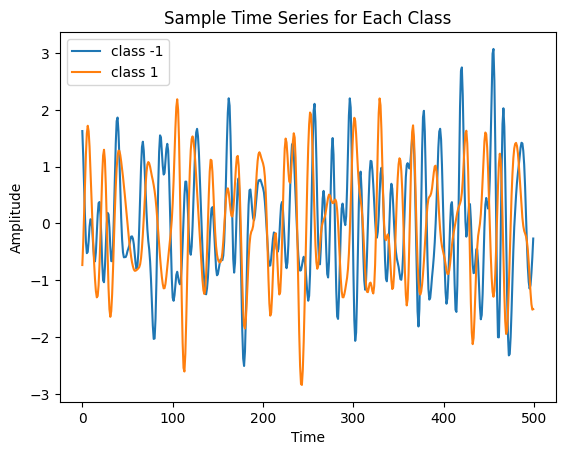

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.9534 - sparse_categorical_accuracy: 0.4877 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.5371
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0.6401 - sparse_categorical_accuracy: 0.5807 - val_loss: 0.4682 - val_sparse_categorical_accuracy: 0.7981
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.4508 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.4443 - val_sparse_categorical_accuracy: 0.7898
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3356 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4668 - val_sparse_categorical_accuracy: 0.7651
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.4254 - val_sparse_categorical_accuracy: 0.7995
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.2096 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.3602 - val_sparse_categorical_accuracy: 0.8393


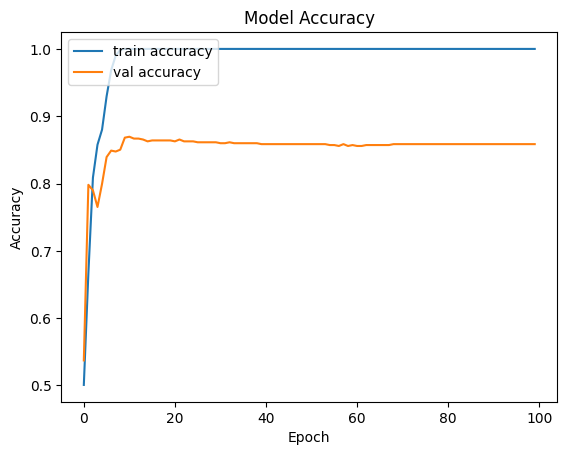

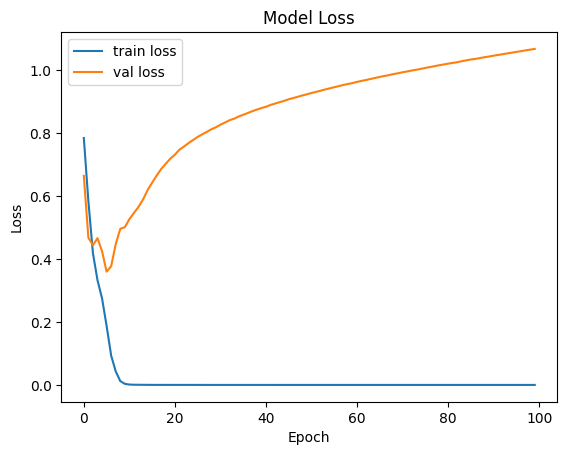

In [1]:
# Import necessary libraries
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the data using Pandas
def readucr(filename):
    # Read the TSV file
    data = pd.read_csv(filename, delimiter="\t", header=None)

    # Convert to numpy arrays
    y = data.iloc[:, 0].to_numpy()
    x = data.iloc[:, 1:].to_numpy()

    # Return features and labels
    return x, y.astype(int)

# Load the training and test datasets
x_train, y_train = readucr("Engine_TRAIN.tsv")
x_test, y_test = readucr("Engine_TEST.tsv")

# Check for inconsistent rows and drop them
if x_train.shape[1] != x_test.shape[1]:
    raise ValueError("Training and test data have different number of features.")

# Visualize the data
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.title("Sample Time Series for Each Class")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
plt.close()

# Standardize the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

# Shuffle the training set
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# Standardize the labels to positive integers
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Build a model
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    # Convolutional layers
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.ReLU()(conv1)
    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.ReLU()(conv2)

    # Flatten and dense layers
    flat1 = keras.layers.Flatten()(conv2)
    dense1 = keras.layers.Dense(256, activation="relu")(flat1)
    dense2 = keras.layers.Dense(64, activation="relu")(dense1)

    # Output layer
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# Create and compile the model
model = make_model(input_shape=x_train.shape[1:])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# Train the model
epochs = 100
batch_size = 64

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    )
]

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='train accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
